In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
import os

# Ruta del directorio de datos
train_dir = 'F:/tomato/train'  # Cambia esta ruta por la de tu dataset
save_dir = 'saved_models'  # Directorio donde se guardarán los modelos
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
# Hiperparámetros
batch_size = 32
epochs = 5
num_folds = 3  # Número de pliegues para K-Fold Cross-Validation
image_size = (64, 64)

# Cargar el conjunto de datos
train_datagen = ImageDataGenerator(rescale=1./255)  # Normalización de imágenes

# Crear el generador de entrenamiento (usamos la misma ruta de entrenamiento para todos los pliegues)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',  # Usa 'sparse' para clasificación multiclase
    shuffle=True
)

results = []

# K-Fold Cross Validation
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Extraer las etiquetas para cada imagen
labels = train_generator.classes

# Número total de imágenes
num_samples = len(labels)

print(f"Total de imágenes: {num_samples}")

# Función para construir EfficientNetB0 con diferentes parámetros
def build_efficientnetb0(input_shape=(128, 128, 3), num_classes=10, dropout_rate=0.5, dense_units=1024, freeze_layers=50):
    base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Congelar las primeras 'freeze_layers' capas
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False
    
    model = tf.keras.models.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(dense_units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Función para construir MobileNetV2 con diferentes parámetros
def build_mobilenetv2(input_shape=(128, 128, 3), num_classes=10, dropout_rate=0.5, dense_units=1024, freeze_layers=50):
    base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Congelar las primeras 'freeze_layers' capas
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False
    
    model = tf.keras.models.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(dense_units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Función para construir VGG16 con diferentes parámetros
def build_vgg16(input_shape=(128, 128, 3), num_classes=10, dropout_rate=0.5, dense_units=1024, freeze_layers=50):
    base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Congelar las primeras 'freeze_layers' capas
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False
    
    model = tf.keras.models.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(dense_units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# K-Fold Cross-Validation con los modelos ligeros
for fold, (train_idx, val_idx) in enumerate(kfold.split(np.zeros(num_samples), labels)):
    print(f"\nEntrenando para el pliegue {fold + 1}/{num_folds}...")
    print(f"Imágenes de entrenamiento: {len(train_idx)}")
    print(f"Imágenes de validación: {len(val_idx)}")
    
    # Obtener los nombres de las imágenes para cada fold
    train_images = [train_generator.filenames[i] for i in train_idx]
    val_images = [train_generator.filenames[i] for i in val_idx]

    # Crear un generador para el entrenamiento (según los archivos seleccionados en el fold)
    train_datagen_fold = ImageDataGenerator(rescale=1./255)
    train_generator_fold = train_datagen_fold.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='sparse',
        shuffle=True,
        subset=None,  # No usar un subconjunto específico
    )
    
    # Crear un generador para la validación (según los archivos seleccionados en el fold)
    val_datagen_fold = ImageDataGenerator(rescale=1./255)
    val_generator_fold = val_datagen_fold.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='sparse',
        shuffle=False,
        subset=None,  # No usar un subconjunto específico
    )
    
    # Configuraciones a probar
    configurations = [
        {"dropout_rate": 0.5, "dense_units": 1024, "freeze_layers": 50},  # Configuración 1
        {"dropout_rate": 0.3, "dense_units": 512, "freeze_layers": 100}   # Configuración 2
    ]
    
    # Modelos a probar
    models_to_try = [
        ("EfficientNetB0", build_efficientnetb0),
        ("MobileNetV2", build_mobilenetv2),
        ("VGG16", build_vgg16)
    ]
    
    # Iterar sobre las configuraciones y modelos
    for model_name, build_model_fn in models_to_try:
        for config in configurations:
            print(f"\nEntrenando modelo {model_name} con configuración {config}...")
            
            # Crear el modelo para este fold con los parámetros de configuración
            model = build_model_fn(
                input_shape=(64, 64, 3), 
                num_classes=len(train_generator.class_indices), 
                dropout_rate=config['dropout_rate'], 
                dense_units=config['dense_units'], 
                freeze_layers=config['freeze_layers']
            )

            # Entrenar el modelo para el fold actual
            history = model.fit(
                train_generator_fold,
                epochs=epochs,
                validation_data=val_generator_fold,
                verbose=2
            )

             # Guardar el modelo entrenado
            model_filename = f"{model_name}_fold{fold+1}_config{config['dropout_rate']}_{config['dense_units']}.h5"
            model_save_path = os.path.join(save_dir, model_filename)
            model.save(model_save_path)
            print(f"Modelo guardado en: {model_save_path}")

            
            # Calcular la exactitud de entrenamiento y validación
            train_accuracy = history.history['accuracy']
            val_accuracy = history.history['val_accuracy']
            
            # Calcular la desviación estándar de la exactitud
            train_accuracy_std = np.std(train_accuracy)
            val_accuracy_std = np.std(val_accuracy)

            # Almacenar los resultados
            results.append({
                'model_name': model_name,
                'fold': fold + 1,
                'config': config,
                'train_accuracy': np.mean(train_accuracy),
                'train_accuracy_std': train_accuracy_std,
                'val_accuracy': np.mean(val_accuracy),
                'val_accuracy_std': val_accuracy_std
            })

import pandas as pd
results_df = pd.DataFrame(results)


Found 10000 images belonging to 10 classes.
Total de imágenes: 10000

Entrenando para el pliegue 1/3...
Imágenes de entrenamiento: 6666
Imágenes de validación: 3334
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.

Entrenando modelo EfficientNetB0 con configuración {'dropout_rate': 0.5, 'dense_units': 1024, 'freeze_layers': 50}...
Epoch 1/5


C:\Users\kferr\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 - 95s - 303ms/step - accuracy: 0.4534 - loss: 1.5508 - val_accuracy: 0.1244 - val_loss: 2.3893
Epoch 2/5
313/313 - 73s - 232ms/step - accuracy: 0.6927 - loss: 0.8725 - val_accuracy: 0.4533 - val_loss: 1.6792
Epoch 3/5
313/313 - 68s - 218ms/step - accuracy: 0.7766 - loss: 0.6481 - val_accuracy: 0.7713 - val_loss: 0.6434
Epoch 4/5
313/313 - 67s - 214ms/step - accuracy: 0.8165 - loss: 0.5176 - val_accuracy: 0.8398 - val_loss: 0.4587
Epoch 5/5
313/313 - 68s - 216ms/step - accuracy: 0.8480 - loss: 0.4459 - val_accuracy: 0.8078 - val_loss: 0.5234


Modelo guardado en: saved_models\EfficientNetB0_fold1_config0.5_1024.h5

Entrenando modelo EfficientNetB0 con configuración {'dropout_rate': 0.3, 'dense_units': 512, 'freeze_layers': 100}...
Epoch 1/5
313/313 - 83s - 267ms/step - accuracy: 0.3320 - loss: 1.8681 - val_accuracy: 0.1022 - val_loss: 2.4009
Epoch 2/5
313/313 - 63s - 201ms/step - accuracy: 0.4903 - loss: 1.4204 - val_accuracy: 0.1881 - val_loss: 2.6494
Epoch 3/5
313/313 - 62s - 199ms/step - accuracy: 0.5533 - loss: 1.2312 - val_accuracy: 0.2203 - val_loss: 3.1026
Epoch 4/5
313/313 - 62s - 198ms/step - accuracy: 0.6020 - loss: 1.1033 - val_accuracy: 0.1882 - val_loss: 3.3525
Epoch 5/5
313/313 - 62s - 198ms/step - accuracy: 0.6222 - loss: 1.0311 - val_accuracy: 0.1359 - val_loss: 4.4060


Modelo guardado en: saved_models\EfficientNetB0_fold1_config0.3_512.h5

Entrenando modelo MobileNetV2 con configuración {'dropout_rate': 0.5, 'dense_units': 1024, 'freeze_layers': 50}...


C:\Users\kferr\AppData\Local\Temp\ipykernel_18864\2127165996.py:66: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


Epoch 1/5
313/313 - 59s - 189ms/step - accuracy: 0.4880 - loss: 1.5209 - val_accuracy: 0.2664 - val_loss: 3.9951
Epoch 2/5
313/313 - 44s - 141ms/step - accuracy: 0.7651 - loss: 0.6995 - val_accuracy: 0.4823 - val_loss: 2.4527
Epoch 3/5
313/313 - 44s - 141ms/step - accuracy: 0.8512 - loss: 0.4594 - val_accuracy: 0.6086 - val_loss: 1.6775
Epoch 4/5
313/313 - 44s - 140ms/step - accuracy: 0.8921 - loss: 0.3181 - val_accuracy: 0.7362 - val_loss: 0.9392
Epoch 5/5
313/313 - 44s - 140ms/step - accuracy: 0.9205 - loss: 0.2426 - val_accuracy: 0.8256 - val_loss: 0.6388


Modelo guardado en: saved_models\MobileNetV2_fold1_config0.5_1024.h5

Entrenando modelo MobileNetV2 con configuración {'dropout_rate': 0.3, 'dense_units': 512, 'freeze_layers': 100}...
Epoch 1/5
313/313 - 47s - 151ms/step - accuracy: 0.5071 - loss: 1.4562 - val_accuracy: 0.2325 - val_loss: 4.5789
Epoch 2/5
313/313 - 35s - 111ms/step - accuracy: 0.7685 - loss: 0.7046 - val_accuracy: 0.4898 - val_loss: 2.3254
Epoch 3/5
313/313 - 34s - 109ms/step - accuracy: 0.8430 - loss: 0.4559 - val_accuracy: 0.7008 - val_loss: 1.1573
Epoch 4/5
313/313 - 34s - 108ms/step - accuracy: 0.8949 - loss: 0.3201 - val_accuracy: 0.7793 - val_loss: 0.7922
Epoch 5/5
313/313 - 34s - 109ms/step - accuracy: 0.9200 - loss: 0.2354 - val_accuracy: 0.8920 - val_loss: 0.3267


Modelo guardado en: saved_models\MobileNetV2_fold1_config0.3_512.h5

Entrenando modelo VGG16 con configuración {'dropout_rate': 0.5, 'dense_units': 1024, 'freeze_layers': 50}...
Epoch 1/5
313/313 - 131s - 419ms/step - accuracy: 0.3634 - loss: 1.8974 - val_accuracy: 0.5836 - val_loss: 1.4863
Epoch 2/5
313/313 - 132s - 421ms/step - accuracy: 0.5702 - loss: 1.3901 - val_accuracy: 0.6440 - val_loss: 1.1929
Epoch 3/5
313/313 - 129s - 412ms/step - accuracy: 0.6286 - loss: 1.1766 - val_accuracy: 0.6831 - val_loss: 1.0403
Epoch 4/5
313/313 - 130s - 414ms/step - accuracy: 0.6633 - loss: 1.0531 - val_accuracy: 0.7027 - val_loss: 0.9500
Epoch 5/5
313/313 - 130s - 414ms/step - accuracy: 0.6839 - loss: 0.9711 - val_accuracy: 0.7209 - val_loss: 0.8827


Modelo guardado en: saved_models\VGG16_fold1_config0.5_1024.h5

Entrenando modelo VGG16 con configuración {'dropout_rate': 0.3, 'dense_units': 512, 'freeze_layers': 100}...
Epoch 1/5
313/313 - 131s - 418ms/step - accuracy: 0.3329 - loss: 1.9786 - val_accuracy: 0.5705 - val_loss: 1.5785
Epoch 2/5
313/313 - 128s - 408ms/step - accuracy: 0.5554 - loss: 1.4546 - val_accuracy: 0.6330 - val_loss: 1.2600
Epoch 3/5
313/313 - 127s - 407ms/step - accuracy: 0.6186 - loss: 1.2194 - val_accuracy: 0.6676 - val_loss: 1.0961
Epoch 4/5
313/313 - 127s - 407ms/step - accuracy: 0.6556 - loss: 1.0931 - val_accuracy: 0.6973 - val_loss: 0.9946
Epoch 5/5
313/313 - 127s - 407ms/step - accuracy: 0.6742 - loss: 1.0026 - val_accuracy: 0.7092 - val_loss: 0.9254


Modelo guardado en: saved_models\VGG16_fold1_config0.3_512.h5

Entrenando para el pliegue 2/3...
Imágenes de entrenamiento: 6667
Imágenes de validación: 3333
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.

Entrenando modelo EfficientNetB0 con configuración {'dropout_rate': 0.5, 'dense_units': 1024, 'freeze_layers': 50}...
Epoch 1/5
313/313 - 97s - 311ms/step - accuracy: 0.4475 - loss: 1.5872 - val_accuracy: 0.1067 - val_loss: 2.5108
Epoch 2/5
313/313 - 72s - 229ms/step - accuracy: 0.6945 - loss: 0.8863 - val_accuracy: 0.2522 - val_loss: 2.2832
Epoch 3/5
313/313 - 70s - 223ms/step - accuracy: 0.7710 - loss: 0.6559 - val_accuracy: 0.7299 - val_loss: 0.7952
Epoch 4/5
313/313 - 72s - 229ms/step - accuracy: 0.8178 - loss: 0.5361 - val_accuracy: 0.7518 - val_loss: 0.7649
Epoch 5/5
313/313 - 69s - 222ms/step - accuracy: 0.8489 - loss: 0.4337 - val_accuracy: 0.8262 - val_loss: 0.5046


Modelo guardado en: saved_models\EfficientNetB0_fold2_config0.5_1024.h5

Entrenando modelo EfficientNetB0 con configuración {'dropout_rate': 0.3, 'dense_units': 512, 'freeze_layers': 100}...
Epoch 1/5
313/313 - 79s - 252ms/step - accuracy: 0.3399 - loss: 1.8647 - val_accuracy: 0.0998 - val_loss: 2.4605
Epoch 2/5
313/313 - 59s - 187ms/step - accuracy: 0.5030 - loss: 1.3930 - val_accuracy: 0.1971 - val_loss: 2.3841
Epoch 3/5
313/313 - 59s - 188ms/step - accuracy: 0.5629 - loss: 1.2163 - val_accuracy: 0.2148 - val_loss: 2.5096
Epoch 4/5
313/313 - 59s - 188ms/step - accuracy: 0.6024 - loss: 1.1019 - val_accuracy: 0.1115 - val_loss: 5.3663
Epoch 5/5
313/313 - 59s - 188ms/step - accuracy: 0.6203 - loss: 1.0332 - val_accuracy: 0.1829 - val_loss: 3.7848


Modelo guardado en: saved_models\EfficientNetB0_fold2_config0.3_512.h5

Entrenando modelo MobileNetV2 con configuración {'dropout_rate': 0.5, 'dense_units': 1024, 'freeze_layers': 50}...
Epoch 1/5
313/313 - 56s - 179ms/step - accuracy: 0.4868 - loss: 1.5552 - val_accuracy: 0.2480 - val_loss: 4.0745
Epoch 2/5
313/313 - 42s - 135ms/step - accuracy: 0.7479 - loss: 0.7438 - val_accuracy: 0.4633 - val_loss: 2.6198
Epoch 3/5
313/313 - 42s - 134ms/step - accuracy: 0.8377 - loss: 0.4909 - val_accuracy: 0.6383 - val_loss: 1.5145
Epoch 4/5
313/313 - 42s - 134ms/step - accuracy: 0.8844 - loss: 0.3429 - val_accuracy: 0.7169 - val_loss: 1.0924
Epoch 5/5
313/313 - 43s - 139ms/step - accuracy: 0.9134 - loss: 0.2543 - val_accuracy: 0.8392 - val_loss: 0.5251


Modelo guardado en: saved_models\MobileNetV2_fold2_config0.5_1024.h5

Entrenando modelo MobileNetV2 con configuración {'dropout_rate': 0.3, 'dense_units': 512, 'freeze_layers': 100}...
Epoch 1/5
313/313 - 47s - 150ms/step - accuracy: 0.5254 - loss: 1.4333 - val_accuracy: 0.2642 - val_loss: 3.9714
Epoch 2/5
313/313 - 36s - 114ms/step - accuracy: 0.7657 - loss: 0.6920 - val_accuracy: 0.4925 - val_loss: 2.4385
Epoch 3/5
313/313 - 35s - 113ms/step - accuracy: 0.8448 - loss: 0.4500 - val_accuracy: 0.6345 - val_loss: 1.5458
Epoch 4/5
313/313 - 38s - 122ms/step - accuracy: 0.8785 - loss: 0.3568 - val_accuracy: 0.7395 - val_loss: 0.9012
Epoch 5/5
313/313 - 36s - 114ms/step - accuracy: 0.9191 - loss: 0.2424 - val_accuracy: 0.8309 - val_loss: 0.5775


Modelo guardado en: saved_models\MobileNetV2_fold2_config0.3_512.h5

Entrenando modelo VGG16 con configuración {'dropout_rate': 0.5, 'dense_units': 1024, 'freeze_layers': 50}...
Epoch 1/5
313/313 - 137s - 437ms/step - accuracy: 0.3522 - loss: 1.9152 - val_accuracy: 0.5985 - val_loss: 1.4843
Epoch 2/5
313/313 - 133s - 423ms/step - accuracy: 0.5668 - loss: 1.3836 - val_accuracy: 0.6476 - val_loss: 1.1840
Epoch 3/5
313/313 - 138s - 440ms/step - accuracy: 0.6312 - loss: 1.1674 - val_accuracy: 0.6768 - val_loss: 1.0371
Epoch 4/5
313/313 - 132s - 421ms/step - accuracy: 0.6620 - loss: 1.0453 - val_accuracy: 0.7056 - val_loss: 0.9428
Epoch 5/5
313/313 - 127s - 406ms/step - accuracy: 0.6849 - loss: 0.9667 - val_accuracy: 0.7237 - val_loss: 0.8748


Modelo guardado en: saved_models\VGG16_fold2_config0.5_1024.h5

Entrenando modelo VGG16 con configuración {'dropout_rate': 0.3, 'dense_units': 512, 'freeze_layers': 100}...
Epoch 1/5
313/313 - 129s - 413ms/step - accuracy: 0.3375 - loss: 1.9662 - val_accuracy: 0.5771 - val_loss: 1.5665
Epoch 2/5
313/313 - 127s - 405ms/step - accuracy: 0.5642 - loss: 1.4409 - val_accuracy: 0.6362 - val_loss: 1.2517
Epoch 3/5
313/313 - 127s - 404ms/step - accuracy: 0.6220 - loss: 1.2130 - val_accuracy: 0.6738 - val_loss: 1.0927
Epoch 4/5
313/313 - 127s - 405ms/step - accuracy: 0.6547 - loss: 1.0900 - val_accuracy: 0.6940 - val_loss: 0.9927
Epoch 5/5
313/313 - 127s - 405ms/step - accuracy: 0.6778 - loss: 1.0041 - val_accuracy: 0.7125 - val_loss: 0.9263


Modelo guardado en: saved_models\VGG16_fold2_config0.3_512.h5

Entrenando para el pliegue 3/3...
Imágenes de entrenamiento: 6667
Imágenes de validación: 3333
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.

Entrenando modelo EfficientNetB0 con configuración {'dropout_rate': 0.5, 'dense_units': 1024, 'freeze_layers': 50}...
Epoch 1/5
313/313 - 130s - 417ms/step - accuracy: 0.4569 - loss: 1.5639 - val_accuracy: 0.1264 - val_loss: 2.4463
Epoch 2/5
313/313 - 68s - 218ms/step - accuracy: 0.7035 - loss: 0.8591 - val_accuracy: 0.3916 - val_loss: 1.7771
Epoch 3/5
313/313 - 68s - 217ms/step - accuracy: 0.7887 - loss: 0.6247 - val_accuracy: 0.7790 - val_loss: 0.6457
Epoch 4/5
313/313 - 67s - 215ms/step - accuracy: 0.8251 - loss: 0.5044 - val_accuracy: 0.6034 - val_loss: 1.1845
Epoch 5/5
313/313 - 68s - 217ms/step - accuracy: 0.8474 - loss: 0.4329 - val_accuracy: 0.7919 - val_loss: 0.5839


Modelo guardado en: saved_models\EfficientNetB0_fold3_config0.5_1024.h5

Entrenando modelo EfficientNetB0 con configuración {'dropout_rate': 0.3, 'dense_units': 512, 'freeze_layers': 100}...
Epoch 1/5
313/313 - 82s - 262ms/step - accuracy: 0.3375 - loss: 1.8433 - val_accuracy: 0.1137 - val_loss: 2.4189
Epoch 2/5
313/313 - 61s - 194ms/step - accuracy: 0.4998 - loss: 1.3963 - val_accuracy: 0.1058 - val_loss: 4.2227
Epoch 3/5
313/313 - 61s - 196ms/step - accuracy: 0.5711 - loss: 1.1939 - val_accuracy: 0.2314 - val_loss: 3.4420
Epoch 4/5
313/313 - 62s - 197ms/step - accuracy: 0.6038 - loss: 1.0939 - val_accuracy: 0.1753 - val_loss: 5.0928
Epoch 5/5
313/313 - 62s - 198ms/step - accuracy: 0.6263 - loss: 1.0376 - val_accuracy: 0.1695 - val_loss: 4.2246


Modelo guardado en: saved_models\EfficientNetB0_fold3_config0.3_512.h5

Entrenando modelo MobileNetV2 con configuración {'dropout_rate': 0.5, 'dense_units': 1024, 'freeze_layers': 50}...
Epoch 1/5
313/313 - 57s - 182ms/step - accuracy: 0.4823 - loss: 1.5574 - val_accuracy: 0.1763 - val_loss: 6.3319
Epoch 2/5
313/313 - 43s - 138ms/step - accuracy: 0.7487 - loss: 0.7421 - val_accuracy: 0.3678 - val_loss: 3.7237
Epoch 3/5
313/313 - 43s - 137ms/step - accuracy: 0.8368 - loss: 0.4869 - val_accuracy: 0.6167 - val_loss: 1.7171
Epoch 4/5
313/313 - 43s - 138ms/step - accuracy: 0.8854 - loss: 0.3387 - val_accuracy: 0.7652 - val_loss: 0.8708
Epoch 5/5
313/313 - 43s - 137ms/step - accuracy: 0.9194 - loss: 0.2380 - val_accuracy: 0.8979 - val_loss: 0.3152


Modelo guardado en: saved_models\MobileNetV2_fold3_config0.5_1024.h5

Entrenando modelo MobileNetV2 con configuración {'dropout_rate': 0.3, 'dense_units': 512, 'freeze_layers': 100}...
Epoch 1/5
313/313 - 44s - 141ms/step - accuracy: 0.5194 - loss: 1.4334 - val_accuracy: 0.2724 - val_loss: 3.4496
Epoch 2/5
313/313 - 35s - 112ms/step - accuracy: 0.7691 - loss: 0.6915 - val_accuracy: 0.4277 - val_loss: 2.5042
Epoch 3/5
313/313 - 35s - 112ms/step - accuracy: 0.8448 - loss: 0.4508 - val_accuracy: 0.6404 - val_loss: 1.3518
Epoch 4/5
313/313 - 37s - 117ms/step - accuracy: 0.8899 - loss: 0.3252 - val_accuracy: 0.7934 - val_loss: 0.6975
Epoch 5/5
313/313 - 36s - 114ms/step - accuracy: 0.9162 - loss: 0.2505 - val_accuracy: 0.9058 - val_loss: 0.2759


Modelo guardado en: saved_models\MobileNetV2_fold3_config0.3_512.h5

Entrenando modelo VGG16 con configuración {'dropout_rate': 0.5, 'dense_units': 1024, 'freeze_layers': 50}...
Epoch 1/5
313/313 - 129s - 413ms/step - accuracy: 0.3532 - loss: 1.9166 - val_accuracy: 0.5849 - val_loss: 1.4771
Epoch 2/5
313/313 - 128s - 410ms/step - accuracy: 0.5706 - loss: 1.3752 - val_accuracy: 0.6515 - val_loss: 1.1764
Epoch 3/5
313/313 - 128s - 410ms/step - accuracy: 0.6264 - loss: 1.1679 - val_accuracy: 0.6859 - val_loss: 1.0323
Epoch 4/5
313/313 - 130s - 415ms/step - accuracy: 0.6690 - loss: 1.0337 - val_accuracy: 0.7024 - val_loss: 0.9420
Epoch 5/5
313/313 - 129s - 411ms/step - accuracy: 0.6860 - loss: 0.9623 - val_accuracy: 0.7194 - val_loss: 0.8790


Modelo guardado en: saved_models\VGG16_fold3_config0.5_1024.h5

Entrenando modelo VGG16 con configuración {'dropout_rate': 0.3, 'dense_units': 512, 'freeze_layers': 100}...
Epoch 1/5
313/313 - 129s - 413ms/step - accuracy: 0.3400 - loss: 1.9734 - val_accuracy: 0.5746 - val_loss: 1.5879
Epoch 2/5
313/313 - 127s - 407ms/step - accuracy: 0.5553 - loss: 1.4577 - val_accuracy: 0.6287 - val_loss: 1.2702
Epoch 3/5
313/313 - 132s - 423ms/step - accuracy: 0.6205 - loss: 1.2287 - val_accuracy: 0.6630 - val_loss: 1.1059
Epoch 4/5
313/313 - 128s - 408ms/step - accuracy: 0.6476 - loss: 1.1018 - val_accuracy: 0.6872 - val_loss: 1.0095
Epoch 5/5
313/313 - 130s - 416ms/step - accuracy: 0.6763 - loss: 1.0151 - val_accuracy: 0.7091 - val_loss: 0.9298


Modelo guardado en: saved_models\VGG16_fold3_config0.3_512.h5


In [3]:
results_df

,model_name,fold,config,train_accuracy,train_accuracy_std,val_accuracy,val_accuracy_std
0,EfficientNetB0,1,"{'dropout_rate': 0.5, 'dense_units': 1024, 'fr...",0.71744,0.141907,0.59932,0.274861
1,EfficientNetB0,1,"{'dropout_rate': 0.3, 'dense_units': 512, 'fre...",0.51996,0.104407,0.16694,0.042194
2,MobileNetV2,1,"{'dropout_rate': 0.5, 'dense_units': 1024, 'fr...",0.78338,0.156719,0.58382,0.196648
3,MobileNetV2,1,"{'dropout_rate': 0.3, 'dense_units': 512, 'fre...",0.78670,0.149099,0.61888,0.233663
4,VGG16,1,"{'dropout_rate': 0.5, 'dense_units': 1024, 'fr...",0.58188,0.115836,0.66686,0.048833
5,VGG16,1,"{'dropout_rate': 0.3, 'dense_units': 512, 'fre...",0.56734,0.124049,0.65552,0.050017
6,EfficientNetB0,2,"{'dropout_rate': 0.5, 'dense_units': 1024, 'fr...",0.71594,0.143948,0.53336,0.294343
7,EfficientNetB0,2,"{'dropout_rate': 0.3, 'dense_units': 512, 'fre...",0.52570,0.101245,0.16122,0.046632
8,MobileNetV2,2,"{'dropout_rate': 0.5, 'dense_units': 1024, 'fr...",0.77404,0.154171,0.58114,0.206476
9,MobileNetV2,2,"{'dropout_rate': 0.3, 'dense_units': 512, 'fre...",0.78670,0.140037,0.59232,0.198992


In [12]:
results_df.to_csv("resultados.csv", index=False)

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ruta de los directorios de datos
train_dir = 'F:/tomato/train'  # Directorio de entrenamiento
val_dir = 'F:/tomato/val'  # Directorio de validación

# Hiperparámetros
batch_size = 32
epochs = 5
image_size = (64, 64)  # Tamaño de la imagen

# Cargar el conjunto de datos de entrenamiento y validación
train_datagen = ImageDataGenerator(rescale=1./255,)  # 20% para validación

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',  # Usa 'sparse' para clasificación multiclase
    shuffle=True,
    subset='training'  # Subconjunto de entrenamiento
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',  # Usa 'sparse' para clasificación multiclase
    shuffle=False  # No barajar en validación
)

# Cargar el modelo VGG16 preentrenado, congelando las capas anteriores
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Congelar las primeras 50 capas
for layer in base_model.layers[:50]:
    layer.trainable = False

# Crear el modelo añadiendo capas personalizadas sobre VGG16
model = models.Sequential([
    base_model,  # VGG16 base model
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),  # Capas densas
    layers.Dropout(0.5),  # Dropout para evitar sobreajuste
    layers.Dense(train_generator.num_classes, activation='softmax')  # Capa de salida con número de clases
])

# Compilar el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)



Found 10000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 95s 301ms/step - accuracy: 0.5173 - loss: 1.4372 - val_accuracy: 0.7390 - val_loss: 0.7827
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 79s 252ms/step - accuracy: 0.7178 - loss: 0.8046 - val_accuracy: 0.7450 - val_loss: 0.7361
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 79s 253ms/step - accuracy: 0.7663 - loss: 0.6751 - val_accuracy: 0.7840 - val_loss: 0.6363
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 79s 254ms/step - accuracy: 0.7865 - loss: 0.6083 - val_accuracy: 0.7770 - val_loss: 0.6421
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 77s 247ms/step - accuracy: 0.8020 - loss: 0.5590 - val_accuracy: 0.7910 - val_loss: 0.5998


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step
Exactitud: 0.7910
Precisión: 0.7967
Recall: 0.7910
Medida F1: 0.7898


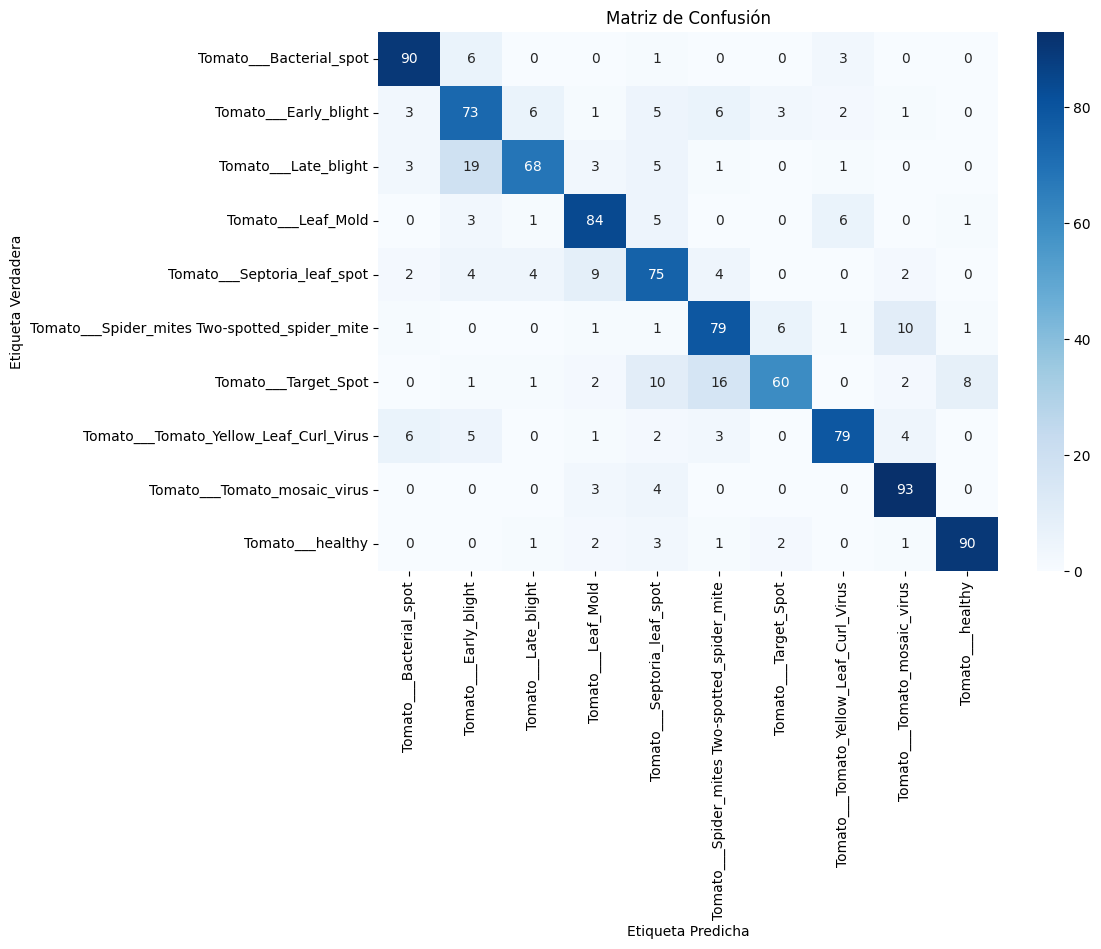

Modelo guardado correctamente.


In [21]:
# Evaluación del modelo
# Obtener predicciones sobre el conjunto de validación
val_generator.reset()  # Resetear el generador de validación
predictions = model.predict(val_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las verdaderas etiquetas
true_classes = val_generator.classes

# Calcular métricas
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

# Matriz de confusión
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Imprimir métricas
print(f'Exactitud: {accuracy:.4f}')
print(f'Precisión: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Medida F1: {f1:.4f}')

# Mostrar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión')
plt.show()

# Guardar el modelo entrenado
model.save('F:/tomato/vgg16_model.h5')  # Ruta donde se guardará el modelo

print("Modelo guardado correctamente.")

In [23]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

correct_dir = 'F:/tomato/correct'
incorrect_dir = 'F:/tomato/incorrect'

# Exportar imágenes correctamente clasificadas
correct_count = 0
incorrect_count = 0
# Crear directorios si no existen
os.makedirs(correct_dir, exist_ok=True)
os.makedirs(incorrect_dir, exist_ok=True)

# Hacer predicciones en el conjunto de validación
predictions = model.predict(val_generator, verbose=1)

# Obtener las clases verdaderas y las predicciones
true_classes = val_generator.classes
predicted_classes = np.argmax(predictions, axis=1)

# Lista para almacenar los índices de las imágenes correctas e incorrectas
correct_images = []
incorrect_images = []

# Filtrar las imágenes correctamente y mal clasificadas
for i in range(len(true_classes)):
    if true_classes[i] == predicted_classes[i]:
        correct_images.append(i)
    else:
        incorrect_images.append(i)

# Limitar a 5 imágenes de cada tipo
correct_images = correct_images[:5]
incorrect_images = incorrect_images[:5]

# Función para copiar imágenes al directorio de salida
def copy_images(image_indices, source_dir, target_dir):
    for idx in image_indices:
        # Obtener el nombre del archivo de la imagen
        img_path = os.path.join(source_dir, val_generator.filenames[idx])
        
        # Cargar la imagen
        img = image.load_img(img_path)
        
        # Guardar la imagen en el directorio de destino
        img.save(os.path.join(target_dir, os.path.basename(img_path)))

# Copiar las imágenes correctas e incorrectas
copy_images(correct_images, val_generator.directory, correct_dir)
copy_images(incorrect_images, val_generator.directory, incorrect_dir)

print(f"5 imágenes correctamente clasificadas se han guardado en {correct_dir}")
print(f"5 imágenes incorrectamente clasificadas se han guardado en {incorrect_dir}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step
5 imágenes correctamente clasificadas se han guardado en F:/tomato/correct
5 imágenes incorrectamente clasificadas se han guardado en F:/tomato/incorrect
